## 00. 환경설정

In [1]:
import os
import pandas as pd
import seaborn as sns
import scipy
import numpy as np
import random
from matplotlib import pyplot as plt
from datetime import datetime
from tqdm import tqdm
%matplotlib inline

from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import KNNBasic, KNNWithMeans
from surprise.model_selection.validation import cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

## 01. [Surprise](https://surprise.readthedocs.io/en/stable/index.html) 라이브러리 활용
- CF 관련 머신러닝 라이브러리 Surpise 사용
- kNN CF, MF 등의 알고리즘도 제공

### 데이터 준비

In [2]:
ratings_df = pd.read_csv("../data/ml-latest-small/ratings.csv", encoding='utf-8')

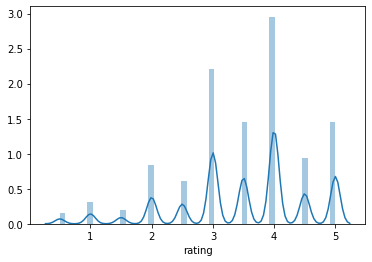

In [3]:
sns.distplot(ratings_df['rating'])

### Surprise 패키지에서 제공하는 dataset과 reader

In [4]:
from surprise import Reader, Dataset

reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

In [5]:
type(data)

surprise.dataset.DatasetAutoFolds

### kNN Model
- [모델 API](https://surprise.readthedocs.io/en/stable/knn_inspired.html)
- [유사도 API](https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#similarity-measures-configuration)

In [6]:
from surprise import accuracy
from surprise.model_selection import train_test_split

# train / test 데이터 나누기, surprise에서 제공하는 함수

train_data, test_data = train_test_split(data, test_size=0.2, random_state=10)

# 기본 KNN 모델을 사용합니다
# user-based

sim_options = {
    'name': 'cosine',
    'user_based': True
}

knnbasic = KNNBasic(k = 40, min_k = 1, sim_options = sim_options)

# 학습 데이터를 가지고 모델을 학습하고, 예측을 수행합니다
knnbasic.fit(train_data)
predictions = knnbasic.test(test_data)

# 모델 성능을 rmse로 계산합니다
accuracy.rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9699


0.969943918550271

In [7]:
len(predictions)

20168

#### cross validation 함수를 지원합니다

In [8]:
user_based_cv_result = cross_validate(knnbasic, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9732  0.9733  0.9672  0.9748  0.9742  0.9726  0.0027  
MAE (testset)     0.7524  0.7502  0.7461  0.7475  0.7486  0.7490  0.0022  
Fit time          1.20    1.71    1.72    1.46    1.45    1.51    0.19    
Test time         3.13    4.19    3.80    3.94    3.45    3.70    0.37    


#### Item-based 추천

In [9]:
sim_options = {
    'name': 'cosine',
    'user_based': False # item-based
}

knnbasic = KNNBasic(k = 40, min_k = 1, sim_options = sim_options)

# 학습 데이터를 가지고 모델을 학습하고, 예측을 수행합니다
knnbasic.fit(train_data)
predictions = knnbasic.test(test_data)

# 모델 성능을 rmse로 계산합니다
accuracy.rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9765


0.9764701105938001

In [10]:
item_based_cv_result = cross_validate(knnbasic, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9687  0.9816  0.9807  0.9752  0.9682  0.9749  0.0057  
MAE (testset)     0.7549  0.7637  0.7652  0.7603  0.7560  0.7600  0.0041  
Fit time          35.76   29.82   28.10   28.39   29.01   30.22   2.84    
Test time         13.00   11.64   11.62   12.01   13.38   12.33   0.73    


### kNN Model with deviation
- 평점을 예측할 때, 사용자 혹은 아이템의 평균 평점을 고려하여 예측하는 모델
- predicted rating = average rating + predicted deviation

In [11]:
# KNN with Means
# user-based

sim_options = {
    'name': 'cosine',
    'user_based': True
}

knnbasic = KNNWithMeans(k = 40, min_k = 1, sim_options = sim_options)

knnbasic.fit(train_data)
predictions = knnbasic.test(test_data)

accuracy.rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9034


0.9033571267064436

#### Item-based

In [12]:
sim_options = {
    'name': 'cosine',
    'user_based': False
}

knnbasic = KNNWithMeans(k = 40, min_k = 1, sim_options = sim_options)

# Train the algorithm on the trainset, and predict ratings for the testset
knnbasic.fit(train_data)
predictions = knnbasic.test(test_data)

# Then compute RMSE
accuracy.rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9031


0.9030789845102651

### 여러 가지 알고리즘, 하이퍼파라미터 비교

In [13]:
benchmark = []

for algorithm in [KNNBasic(), KNNWithMeans()]:
    for k in [10, 20, 40]:
        for similarity in ['cosine', 'msd', 'pearson']:
            for user_based in [True, False]:            
                algorithm.k = k
                algorithm.sim_options = {'name':  similarity, 'user_based': user_based}
                results = cross_validate(algorithm, data, measures=['RMSE'], cv=2, verbose=False)

                # Get results & append algorithm name
                rmse = results['test_rmse'].mean()
                benchmark.append([str(algorithm.__class__.__name__), k, similarity, user_based, rmse])

benchmark_df = pd.DataFrame(benchmark,
                            columns = ['algorithm', 'k', 'similarity', 'user_based', 'rmse']
                           ).sort_values(by='rmse')

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine

In [14]:
benchmark_df

,algorithm,k,similarity,user_based,rmse
33,KNNWithMeans,40,msd,False,0.914445
32,KNNWithMeans,40,msd,True,0.921171
27,KNNWithMeans,20,msd,False,0.921212
26,KNNWithMeans,20,msd,True,0.921375
24,KNNWithMeans,20,cosine,True,0.922970
30,KNNWithMeans,40,cosine,True,0.923521
15,KNNBasic,40,msd,False,0.925583
31,KNNWithMeans,40,cosine,False,0.926080
20,KNNWithMeans,10,msd,True,0.928613
34,KNNWithMeans,40,pearson,True,0.930003


## 02. 추천 결과 서빙
- 위에서 수행한 오프라인 테스트 결과를 바탕으로 모델을 선택합니다.
- 실제 프로덕션에 적용할 때는 train/test를 나누지 않고 지금까지 쌓인 모든 데이터를 가지고 학습하여 모델을 만듭니다.

#### 제일 좋은 성능을 낸 모델로 추천 서빙

In [15]:
sim_options = {
    'name': 'msd',
    'user_based': False
}

knn = KNNWithMeans(k = 40, min_k = 1, sim_options = sim_options)

# 전체 데이터를 가지고 학습데이터를 만든다
full_train_data = data.build_full_trainset()
knn.fit(full_train_data)

Computing the msd similarity matrix...
Done computing similarity matrix.


#### user 1의 item 29에 대한 평점을 구한다면
- [predict method](https://surprise.readthedocs.io/en/stable/algobase.html#surprise.prediction_algorithms.algo_base.AlgoBase.predict)

In [16]:
knn.predict(1, 29)

Prediction(uid=1, iid=29, r_ui=None, est=4.900674110940887, details={'actual_k': 40, 'was_impossible': False})

In [17]:
# user 1에 대해서 rating이 없는 영화 가운데 추천을 해봅시다
user_id = 1

# 전체 영화 리스트 가운데서 user 1이 이미 평가한 영화를 제거합니다
candidate_itemlist = list(set(ratings_df['movieId'].unique()) \
                    - set(ratings_df[ratings_df['userId'] == user_id]['movieId'].unique()))

In [18]:
len(candidate_itemlist)

9492

In [19]:
def recommend_highest_rating_from_user(user_id, item_ids, algorithm, k):
    
    _result = []
    
    # 받은 영화 리스트에 대해서 평점을 구합니다
    for item_id in item_ids:
        pred_rating = algorithm.predict(user_id, item_id).est
        _result.append([item_id, pred_rating])
    
    # 평점을 기준으로 정렬하여 k개를 return합니다
    ratings = pd.DataFrame(_result, columns=['movieId', 'predRating']).sort_values(by='predRating', ascending=False)
    return ratings[:k]

In [20]:
%%time
recommend_highest_rating_from_user(user_id, candidate_itemlist, knn, 10)

Wall time: 3.52 s


,movieId,predRating
6400,164917,5.0
6316,107951,5.0
9468,98154,5.0
4577,71462,5.0
2627,3330,5.0
7136,147196,5.0
7138,147250,5.0
3114,3942,5.0
4585,5938,5.0
4595,5949,5.0


#### 실제 서비스에서는 모든 아이템에 대해서 예측 평점을 구해서 정렬하기 어렵기 때문에 아래와 같은 방법을 사용하기도 합니다

In [21]:
def recommend_higher_than_threshold_from_user(user_id, item_ids, algorithm, k, threshold):
    random.shuffle(item_ids)
    _result = []
    for item_id in item_ids:
        pred_rating = algorithm.predict(user_id, item_id).est
        if pred_rating >= threshold:
            _result.append([item_id, pred_rating])
            
        if len(_result) >= k:
            break
        
    ratings = pd.DataFrame(_result, columns=['movieId', 'predRating']).sort_values(by='predRating', ascending=False)
    return ratings

In [22]:
%%time
recommend_higher_than_threshold_from_user(user_id, candidate_itemlist, knn, 10, 4.5)

Wall time: 23.9 ms


,movieId,predRating
1,6201,5.000000
3,47423,5.000000
6,7981,5.000000
7,33201,5.000000
4,100159,4.999819
9,3569,4.831323
8,111362,4.718940
5,4465,4.670411
2,121,4.648007
0,94677,4.507225
